# DSP experiments

This notebook contains DSP experiments to assess the accuracy of confidence level classification of climate statements by various LLMs.

In [1]:
# try: 
#     # This library is our indicator that the required installs
#     # need to be done.
#     import datasets
#     root_path = '.'
# except ModuleNotFoundError:
#     !git clone https://github.com/cgpotts/cs224u/
#     !pip install -r cs224u/requirements.txt
#     root_path = 'dsp'

Now we import modules to work with DSP, OpenAI, HuggingFace, and Cohere models

In [2]:
import pandas as pd 
# import cohere
from datasets import load_dataset
import openai
import re
import os
import dsp
import transformers

c:\Users\yunlo\anaconda3\envs\ChatIAMs0528-2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now we import key variables such as API keys. Steps:

1) Create a keys.txt file in the root of your /content/ folder in the Colab instance

2) Define the API keys you will use 

3) Run the cell below to import the file

In [3]:
# Read the contents of the file
# with open('/content/keys.txt', 'r') as file:
#     file_contents = file.read()

# # Assign the variables
# exec(file_contents)

# os.environ["DSP_NOTEBOOK_CACHEDIR"] = os.path.join(root_path, 'cache')
# openai_key = OPENAI_API_KEY  
# cohere_key = COHERE_API_KEY  

# OpenAI API
from getpass import getpass
import os
import openai
from openai import OpenAI

# from dotenv import load_dotenv, find_dotenv
# _ = load_dotenv(find_dotenv()) # read local .env file
new_api_key = getpass()

os.environ["OPENAI_API_KEY"] = new_api_key
openai.api_key = os.environ['OPENAI_API_KEY']
openai_key = openai.api_key
openai_client = OpenAI()

## Model setting

Now we define a choice of LM and setup the DSP environment.

In [4]:
# [d["root"] for d in openai.Model.list(api_key=openai_key)["data"]]

In [5]:
## Define the mode (uncomment appropriate line)

lm = dsp.GPT3(model = "gpt-3.5-turbo", api_key=openai_key, model_type="chat")
#lm = dsp.GPT3(model = "gpt-4", api_key=openai_key, model_type="chat")
#lm = dsp.Cohere(model = "command-xlarge-nightly", api_key=cohere_key)

dsp.settings.configure(lm=lm)
dsp.settings.show_guidelines = True

### Loading the dataset
Upload a tab separated version of the dataset to /content/.

In [6]:
df = pd.read_csv('ipcc_statements_dataset.tsv', sep='\t', skiprows=0)

train_set = df.loc[df['split'] == 'train']
test_set = df.loc[df['split'] == 'test']

test_set.tail

<bound method NDFrame.tail of       statement_idx     report  page_num  sent_num  \
3                 3    AR6_WGI        24         2   
42               42    AR6_WGI        37        16   
77               77    AR6_WGI        47         7   
81               81    AR6_WGI        62         2   
86               86    AR6_WGI        63         8   
...             ...        ...       ...       ...   
8024           8024  AR6_WGIII      1827        13   
8056           8056  AR6_WGIII      2011         5   
8067           8067  AR6_WGIII      2012         8   
8086           8086  AR6_WGIII      2016         8   
8093           8093  AR6_WGIII      2058        21   

                                              statement confidence  score  \
3     Since 1750, increases in CO2 (47%) and CH4 (15...  very high      3   
42    Over the next 2000 years, global mean sea leve...        low      0   
77    By the end of the century, scenarios with very...       high      2   
81    Over th

In [7]:
ipcc_train = [dsp.Example(input=row['statement'], label=row['confidence'], score=row['score'], report=row['report'])
                    for _, row in train_set.iterrows()]

In [8]:
ipcc_train[:5]

[{'input': 'Since 2011 (measurements reported in AR5), concentrations have continued to increase in the atmosphere, reaching annual averages of 410 parts per million (ppm) for carbon dioxide (CO 2), 1866 parts per billion (ppb) for methane (CH 4), and 332 ppb for nitrous oxide (N 2O) in 2019.6 Land and ocean have taken up a near-constant proportion (globally about 56% per year) of CO 2 emissions from human activities over the past six decades, with regional differences',
  'label': 'high',
  'score': 2,
  'report': 'AR6_WGI'},
 {'input': 'Mid-latitude storm tracks have likely shifted poleward in both hemispheres since the 1980s, with marked seasonality in trends',
  'label': 'medium',
  'score': 1,
  'report': 'AR6_WGI'},
 {'input': 'The average rate of sea level rise was 1.3 [0.6 to 2.1] mm yr–1 between 1901 and 1971, increasing to 1.9 [0.8 to 2.9] mm yr–1 between 1971 and 2006, and further increasing to 3.7 [3.2 to 4.2] mm yr–1 between 2006 and 2018',
  'label': 'high',
  'score': 2,

### Perform checks on dataset


In [9]:
print(len(ipcc_train))
print(len([ex for ex in ipcc_train if ex.label=='low']))
print(len([ex for ex in ipcc_train if ex.report=='AR6_WGIII']))
print(len([ex for ex in ipcc_train if ex.score==2]))

7794
241
826
4611


## Split train set by confidence level

In [10]:
train_ex = {}
for confidence in ['low', 'medium', 'high', 'very high']: 
  train_ex[confidence] = [ex for ex in ipcc_train if ex.label==confidence]
  print(f"{confidence}: {len(train_ex[confidence])}")

low: 241
medium: 2415
high: 4611
very high: 527


## Defining templates

### Few-shot learning
Testing how models do on the task with demonstrations.

In [11]:
Input = dsp.Type(
    prefix="Statement:", 
    desc="${a short statement about climate.}")

Label = dsp.Type(
    prefix="Confidence: ", 
    desc="${must be *only*: 'low', 'medium', 'high', 'very high'}")

few_shot_template = dsp.Template(
    instructions="You are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change. \
      \n\nYou will be presented with a statement about climate science, climate impacts or climate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?  \
      \n\nRespond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.",
    input=Input(),
    label=Label())

Example:

In [12]:
ex = dsp.Example(
    input=ipcc_train[0]['input'], label=ipcc_train[0]['label'])

ex.demos=dsp.sample(ipcc_train, 3)

print(few_shot_template(ex))

You are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change.       

You will be presented with a statement about climate science, climate impacts or climate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?        

Respond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.

---

Follow the following format.

Statement: ${a short statement about climate.}
Confidence: ${must be *only*: 'low', 'medium', 'high', 'very high'}

---

Statement: Experiments indicate that warming reduces calcification by coralline algae
Confidenc

## Defining the task

With zero shot we simply provide instructions and provide a format template, with no training demonstrations.

In [13]:
import random

@dsp.transformation
def assess_certainty_with_demonstrations(example, temperature=0): 
    
    # Sample demonstrations in train set for each confidence level
    example.demos = []
    for confidence in ['low', 'medium', 'high', 'very high']:
        demo = random.choice(train_ex[confidence])
        example.demos.append(demo)

    # Call LLM
    example, completion = dsp.generate(few_shot_template,  temperature=temperature)(example, stage='few-shot')

    return completion

def extract_confidence(text):
    if re.search(r"low", text, re.IGNORECASE):
        return "low"
    elif re.search(r"medium", text, re.IGNORECASE):
        return "medium"
    elif re.search(r"very high", text, re.IGNORECASE):
        return "very high"
    elif re.search(r"high", text, re.IGNORECASE):
        return "high"
    elif re.search(r"i don't know", text, re.IGNORECASE):
        return "idk"
    else:
        return "N/A"

Testing our task on the first sentence of the dataset: gpt3.5-turbo gets this first task right!

In [14]:
print(ex)
assess_certainty_with_demonstrations(ex).label

{'input': 'Since 2011 (measurements reported in AR5), concentrations have continued to increase in the atmosphere, reaching annual averages of 410 parts per million (ppm) for carbon dioxide (CO 2), 1866 parts per billion (ppb) for methane (CH 4), and 332 ppb for nitrous oxide (N 2O) in 2019.6 Land and ocean have taken up a near-constant proportion (globally about 56% per year) of CO 2 emissions from human activities over the past six decades, with regional differences', 'label': 'high', 'demos': [{'input': 'Experiments indicate that warming reduces calcification by coralline algae', 'label': 'high', 'score': 2, 'report': 'AR6_WGII'}, {'input': 'For 2150, sea level is likely to reach 0.52 m [0.32–0.81] for SSP1- 1.9, to 1.22 [0.91–1.78] for SSP5-8.5 relative to 1996–2014', 'label': 'medium', 'score': 1, 'report': 'AR6_WGII'}, {'input': 'The limited gains from AFOLU to date appear largely to result from lack of investment and other institutional and social barriers, rather than methodolo

'high'

In [15]:
lm.inspect_history(n=1)




You are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change.       

You will be presented with a statement about climate science, climate impacts or climate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?        

Respond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.

---

Follow the following format.

Statement: ${a short statement about climate.}
Confidence: ${must be *only*: 'low', 'medium', 'high', 'very high'}

---

Statement: Indigenous Peoples have the highest levels of vulnerability in Chile in terms of 

"\n\n\nYou are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change.       \n\nYou will be presented with a statement about climate science, climate impacts or climate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?        \n\nRespond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.\n\n---\n\nFollow the following format.\n\nStatement: ${a short statement about climate.}\nConfidence: ${must be *only*: 'low', 'medium', 'high', 'very high'}\n\n---\n\nStatement: Indigenous Peoples have the highest levels of vulnerability in

# First experiment

We assess the certainty level of the LM on the dataset, filter the output for extra "confidence" etc., then compare with ground truth.

In [16]:
samples = test_set.copy()  # Dev: train_set.sample(n=100, random_state=12).copy() | Experiment: test_set.copy()

samples.head

<bound method NDFrame.head of       statement_idx     report  page_num  sent_num  \
3                 3    AR6_WGI        24         2   
42               42    AR6_WGI        37        16   
77               77    AR6_WGI        47         7   
81               81    AR6_WGI        62         2   
86               86    AR6_WGI        63         8   
...             ...        ...       ...       ...   
8024           8024  AR6_WGIII      1827        13   
8056           8056  AR6_WGIII      2011         5   
8067           8067  AR6_WGIII      2012         8   
8086           8086  AR6_WGIII      2016         8   
8093           8093  AR6_WGIII      2058        21   

                                              statement confidence  score  \
3     Since 1750, increases in CO2 (47%) and CH4 (15...  very high      3   
42    Over the next 2000 years, global mean sea leve...        low      0   
77    By the end of the century, scenarios with very...       high      2   
81    Over th

In [17]:
samples['prediction'] = samples.statement.apply(
    lambda x: extract_confidence(assess_certainty_with_demonstrations(dsp.Example(input=x, demos=dsp.sample(ipcc_train, 0)), temperature=0).label.lower()))

In [18]:
lm.inspect_history(n=1)




You are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change.       

You will be presented with a statement about climate science, climate impacts or climate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?        

Respond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.

---

Follow the following format.

Statement: ${a short statement about climate.}
Confidence: ${must be *only*: 'low', 'medium', 'high', 'very high'}

---

Statement: Nevertheless, the most- advanced available models, which incorporate multiple coa

"\n\n\nYou are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change.       \n\nYou will be presented with a statement about climate science, climate impacts or climate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?        \n\nRespond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.\n\n---\n\nFollow the following format.\n\nStatement: ${a short statement about climate.}\nConfidence: ${must be *only*: 'low', 'medium', 'high', 'very high'}\n\n---\n\nStatement: Nevertheless, the most- advanced available models, which incor

In [19]:
samples['correct'] = samples.apply(
    lambda row: (row['confidence'] == row['prediction']), axis=1)

print(f"Accuracy: {samples['correct'].sum() / (samples.shape[0]-len(samples[samples['prediction'] == 'idk'])):.3f}")
print(f"'I don't know': {len(samples[samples['prediction'] == 'idk'])}")
print(f"N/A: {len(samples[samples['prediction'] == 'N/A'])}")

Accuracy: 0.365
'I don't know': 1
N/A: 0


In [20]:
samples.loc[samples['confidence'] == 'low'].head

<bound method NDFrame.head of       statement_idx     report  page_num  sent_num  \
42               42    AR6_WGI        37        16   
151             151    AR6_WGI        85        31   
322             322    AR6_WGI       122        19   
621             621    AR6_WGI       336        10   
687             687    AR6_WGI       378        12   
768             768    AR6_WGI       492         1   
974             974    AR6_WGI       735         7   
980             980    AR6_WGI       742        14   
997             997    AR6_WGI       762         3   
1005           1005    AR6_WGI       779        14   
1185           1185    AR6_WGI       969        37   
1263           1263    AR6_WGI      1075        19   
1510           1510    AR6_WGI      1289        12   
1567           1567    AR6_WGI      1323        10   
1885           1885    AR6_WGI      1826         9   
1906           1906    AR6_WGI      1832         9   
1928           1928    AR6_WGI      1839        27  

## Saving experiment results

Make sure to save the results for future analysis if needed.

In [21]:
samples.to_csv('gpt3.5-turbo-demos-temp0-2024-05-30.csv', index=False)

Alternatively, re-load a previous experiment.

In [22]:
# samples = pd.read_csv('gpt3.5-turbo-demos-temp0-2024-05-30.csv', sep=',', skiprows=0)

## Precision, recall, and F1 score

In [23]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report

true_labels = samples.loc[(samples['prediction'] != 'N/A') & (samples['prediction'] != 'idk'), 'confidence']
predicted_labels = samples.loc[(samples['prediction'] != 'N/A') & (samples['prediction'] != 'idk'), 'prediction']

# Compute macro F1 score
f1 = f1_score(true_labels, predicted_labels, average='macro')
print("Macro F1 score:", f1)

# Compute weighted F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print("Weighted F1 score:", f1)

# Compute precision for each class
precision = precision_score(true_labels, predicted_labels, average=None)

# Compute recall for each class
recall = recall_score(true_labels, predicted_labels, average=None)

# Compute F1 score for each class
f1 = f1_score(true_labels, predicted_labels, average=None)

# Create a dataframe to store precision and recall for each class
class_metrics_df = pd.DataFrame({'Precision': precision, 'Recall': recall, 'F1': f1})

# Add labels to the class metrics dataframe
class_metrics_df['Class'] = true_labels.unique().astype(str)

# Sort the dataframe by class index or name
class_metrics_df = class_metrics_df.sort_values('Class', key=lambda x: pd.Categorical(x, categories=["low", "medium", "high", "very high"]))

# Print class metrics dataframe
#print(class_metrics_df)

# Compute accuracy for the whole system
accuracy = accuracy_score(true_labels, predicted_labels)

# Compute accuracy by class

print("Accuracy (total):", accuracy)

report = classification_report(true_labels, predicted_labels, digits=4)
print(report)

# Count classes
category_counts = true_labels.value_counts()
print(category_counts)



Macro F1 score: 0.2255368576123293
Weighted F1 score: 0.28751399218995605
Accuracy (total): 0.36454849498327757
              precision    recall  f1-score   support

        high     0.4746    0.2800    0.3522       100
         low     0.0000    0.0000    0.0000        50
      medium     0.3376    0.7980    0.4745        99
   very high     0.6667    0.0400    0.0755        50

    accuracy                         0.3645       299
   macro avg     0.3697    0.2795    0.2255       299
weighted avg     0.3820    0.3645    0.2875       299

confidence
high         100
medium        99
very high     50
low           50
Name: count, dtype: int64


## Over/under confidence assessment

In [24]:
# Filter samples
fs = samples.loc[(samples['prediction'] != 'N/A') & (samples['prediction'] != 'idk')] 

# Compute a certainty score
value_map = {'low': 0, 'medium': 1, 'high': 2, 'very high': 3}

fs['predicted_score'] = fs.prediction.apply(
    lambda x: value_map[x])

# Break down scores
scores_all = {
    "low": fs.loc[fs['score'] == 0, 'predicted_score'].mean(),
    "medium": fs.loc[fs['score'] == 1, 'predicted_score'].mean(),
    "high": fs.loc[fs['score'] == 2, 'predicted_score'].mean(),
    "very high": fs.loc[fs['score'] == 3, 'predicted_score'].mean()
}

scores_wg1 = {
    "low": fs.loc[(fs['score'] == 0) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "medium": fs.loc[(fs['score'] == 1) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "high": fs.loc[(fs['score'] == 2) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "very high": fs.loc[(fs['score'] == 3) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean()
}

scores_wg23 = {
    "low": fs.loc[(fs['score'] == 0) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "medium": fs.loc[(fs['score'] == 1) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "high": fs.loc[(fs['score'] == 2) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "very high": fs.loc[(fs['score'] == 3) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean()
}

print("=== All AR6 reports===")
print(f"Average ground truth score: {samples['score'].mean()}")
print(f"Average predicted score: {fs['predicted_score'].mean()}")
print(f"Average scores per category: {scores_all}\n")

print("=== AR6 WGI report ===")
print(f"Average ground truth score: {samples.loc[samples['report'] == 'AR6_WGI', 'score'].mean()}")
print(f"Average predicted score: {fs.loc[fs['report'] == 'AR6_WGI', 'predicted_score'].mean()}")
print(f"Average scores per category: {scores_wg1}\n")

print("=== AR6 WGII/III reports ===")
print(f"Average ground truth score: {samples.loc[samples['report'] != 'AR6_WGI', 'score'].mean()}")
print(f"Average predicted score: {fs.loc[fs['report'] != 'AR6_WGI', 'predicted_score'].mean()}")
print(f"Average scores per category: {scores_wg23}\n")

C:\Users\yunlo\AppData\Local\Temp\ipykernel_21864\201967900.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fs['predicted_score'] = fs.prediction.apply(


=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.2073578595317727
Average scores per category: {'low': 1.04, 'medium': 1.1414141414141414, 'high': 1.3, 'very high': 1.32}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.3404255319148937
Average scores per category: {'low': 1.05, 'medium': 1.2941176470588236, 'high': 1.3666666666666667, 'very high': 2.0}

=== AR6 WGII/III reports ===
Average ground truth score: 1.5853658536585367
Average predicted score: 1.146341463414634
Average scores per category: {'low': 1.0333333333333334, 'medium': 1.0615384615384615, 'high': 1.2714285714285714, 'very high': 1.15}



c:\Users\yunlo\anaconda3\envs\ChatIAMs0528-2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\yunlo\anaconda3\envs\ChatIAMs0528-2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\yunlo\anaconda3\envs\ChatIAMs0528-2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\yunlo\anaconda3\envs\ChatIAMs0528-2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

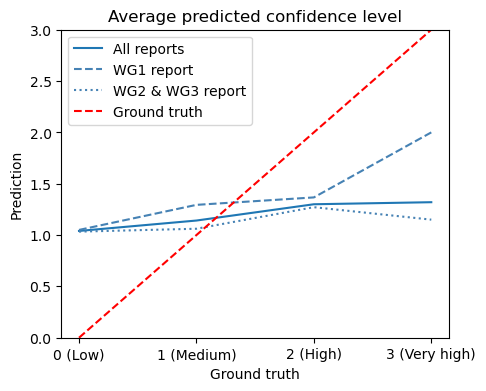

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the data

# Extract labels and values from the data dictionary
labels = list(scores_all.keys())
values_all = list(scores_all.values())
values_wg1 = list(scores_wg1.values())
values_wg23 = list(scores_wg23.values())

# Define the custom labels for the x-axis
x_labels = ['0 (Low)', '1 (Medium)', '2 (High)', '3 (Very high)']

plt.figure(figsize=(5, 4))

# Create the line plot with labeled curve
sns.lineplot(x=labels, y=values_all, label='All reports')
sns.lineplot(x=labels, y=values_wg1, linestyle='--', color="steelblue", label='WG1 report')
sns.lineplot(x=labels, y=values_wg23, linestyle='dotted', color="steelblue", label='WG2 & WG3 report')


# Add the ground truth line (y = x)
x = np.arange(len(labels))
plt.plot(x, x, linestyle='--', color='red', label='Ground truth')

# Customize the x-axis tick labels
plt.xticks(labels, x_labels)

# Set the y-axis limits
plt.ylim(0, 3)

# Set the title and labels
plt.title("Average predicted confidence level")
plt.xlabel("Ground truth")
plt.ylabel("Prediction")


# Show the legend
plt.legend()

# Show the plot
plt.savefig("gpt3.5-fewshot.png", dpi=500)
plt.show()